### **Load Data**

In [2]:
import pandas as pd

# Load data set

def load_data(file_path):
    df = pd.read_csv(file_path)

    return df

file_path = '../data/flight_df.csv'

# load dataset
df = load_data(file_path)

# Select specific columns taken from feature importance
select_columns = [
    'Inflight wifi service',
    'Online boarding',
    'Business Travel',
    'Inflight entertainment',
    'Loyal Customer',
    'Checkin service',
    'Flight Distance',
    'Age',
    'Class',
    'satisfied'
]

# Filter the dataset to use only the selected columns
df=df[select_columns]
df.head()


,Inflight wifi service,Online boarding,Business Travel,Inflight entertainment,Loyal Customer,Checkin service,Flight Distance,Age,Class,satisfied
0,2,2,1,2,1,3,2062,26,3,0
1,5,4,1,4,1,4,680,52,3,1
2,3,3,0,3,1,4,188,28,1,0
3,3,4,1,3,1,4,453,54,3,0
4,4,4,1,4,1,3,775,40,1,0


### **Model Validation**

In [3]:
from sklearn.model_selection import train_test_split

# Define target variable
y =df['satisfied']
X = df.drop(columns='satisfied')

In [4]:
import os

file = '../data/app_flight_df.csv'

try:
    # save the features dataframe
    X.to_csv(file, index=False)
    
    # continue save if successful
    if os.path.exists(file):
        print(f'Dataframe saved successfully to {file}')
        
    else:
        print(f'Error saving dataframe to {file}')
        
except Exception as error:
    print(f'Error using dataframe to {file}: {error}')

Dataframe saved successfully to ../data/app_flight_df.csv


In [5]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Check for class imbalance
y.value_counts(normalize=True)

satisfied
0    0.56695
1    0.43305
Name: proportion, dtype: float64

### **Preprocessing**

In [6]:
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

# Select numeric and categorical columns
num_cols = make_column_selector(dtype_include='number')
cat_cols = make_column_selector(dtype_include='object')

# Instantiate transformer
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore')
imputer = KNNImputer(n_neighbors=2, weights='uniform') # Use KNN algorithm to impute missing values to preserve data integrity

# preprocessing pipeline
def preprocessing_pipeline():
    
    num_pipe = Pipeline([
        ('scaler', scaler),
        ('imputer', imputer)
    ])
    
    cat_pipe = Pipeline([
        ('encoder', encoder)
    ])
    
    preprocessor = ColumnTransformer([
        ('numeric', num_pipe, num_cols),
        ('categorical', cat_pipe, cat_cols)
    ])
    
    return preprocessor

# Create preprocessor object
preprocessor = preprocessing_pipeline()

In [7]:
from imblearn.over_sampling import SMOTE # Synthetic Minority Oversampling TEchnique
from imblearn. pipeline import Pipeline as ImbalancePipeline

# Create sampler pipeline
def sampler_pipeline(sampler):
    
    return ImbalancePipeline([
        ('sampler', sampler)
    ])
    
# Create sampler object
sampler = sampler_pipeline(SMOTE(random_state=42))

# preprocess and rebalance the dataset
def preprocess_and_rebalance(preprocessor, X_train, X_test, y_train):
    
    # transform training data to the fitted transformer
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    # Rebalance training load_data
    X_train_balanced, y_train_balanced = sampler.fit_resample(X_train_transformed, y_train)
    
    return X_train_balanced, X_test_transformed, y_train_balanced

# Preprocess and Rebalance the dataset

X_train_balanced, X_test_transformed, y_train_balanced = preprocess_and_rebalance(preprocessor, X_train, X_test, y_train)

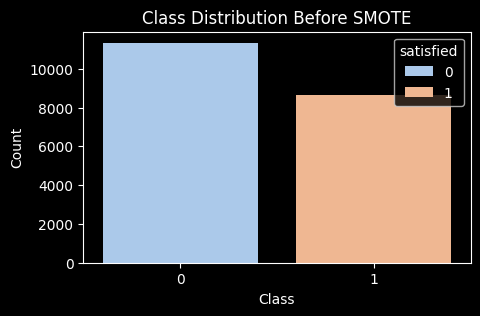

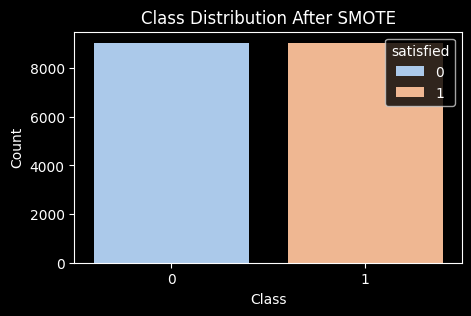

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dark mode
plt.style.use('dark_background')

# Visualize data before SMOTE
def plot_distribution(y, title):
    plt.figure(figsize=(5, 3))
    sns.countplot(
        x=y, # y is the target variable 'satisfied'
        palette = 'pastel',
        hue=y
    )
    
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()
    
# Visualize data before SMOTE
plot_distribution(y, title='Class Distribution Before SMOTE')

# Visualize data after SMOTE
plot_distribution(y_train_balanced, title='Class Distribution After SMOTE')

In [9]:
# Convert preprocessed data back to a dataframe
X_train_balanced_df = pd.DataFrame(X_train_balanced)
X_test_transformed_df = pd.DataFrame(X_test_transformed)

### **Machine Learning**

In [14]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# dark mode
plt.style.use('dark_background')

# Function to evaluate model performance
def evaluate_model(model, X_train, y_train, X_test, y_test):

    # Make predictions
    train_preds = np.rint(model.predict(X_train))
    test_preds = np.rint(model.predict(X_test))

    # Classification report
    train_report = classification_report(y_train, train_preds)
    test_report = classification_report(y_test, test_preds)

    # Confusion matrix
    train_cm = confusion_matrix(y_train, train_preds)
    test_cm = confusion_matrix(y_test, test_preds)

    # Define labels
    labels = ['Not Satisfied', 'Satisfied']

    # Plot confusion matrices side-by-side Training
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # First axis
    axes[0].text(0.01, 0.05, str(train_report), fontproperties='monospace')
    axes[0].axis('off')

    # Second axis
    disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=labels)
    disp_train.plot(ax=axes[1], cmap='Blues')
    axes[1].set_title('Training Confusion Matrix')

    # Plot confusion matrices side-by-side Testing
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # First axis
    axes[0].text(0.01, 0.05, str(test_report), fontproperties='monospace')
    axes[0].axis('off')

    # Second axis
    disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=labels)
    disp_test.plot(ax=axes[1], cmap='Purples')
    axes[1].set_title('Testing Confusion Matrix')

    plt.show()

    return train_report, test_report

In [15]:
# ML pipeline
def train_and_predict(X_train, y_train, X_test, preprocessor, model):
    
    # Complete pipeline and model
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Fit model
    model_pipeline.fit(X_train, y_train)
    
    # Save predictions
    train_preds = model_pipeline.predict(X_train)
    test_preds = model_pipeline.predict(X_test)
    
    return train_preds, test_preds

In [19]:
import lightgbm as lgb

# Instantiate the model
lgb_model = lgb.LGBMClassifier(verbose=-1, random_state=42)

# Create and save predictions
train_preds, test_preds = train_and_predict(X_train_balanced_df, y_train_balanced, X_test_transformed_df, preprocessor, lgb_model)


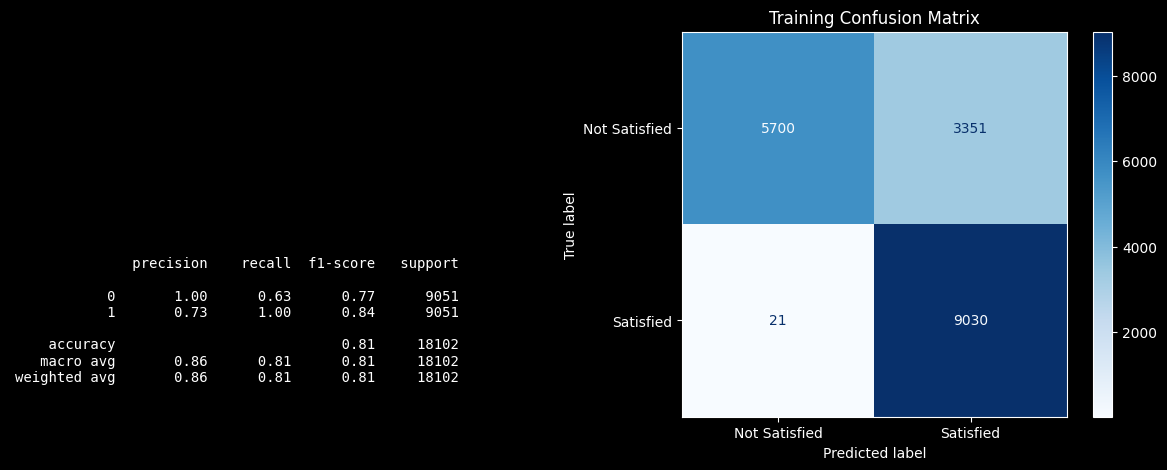

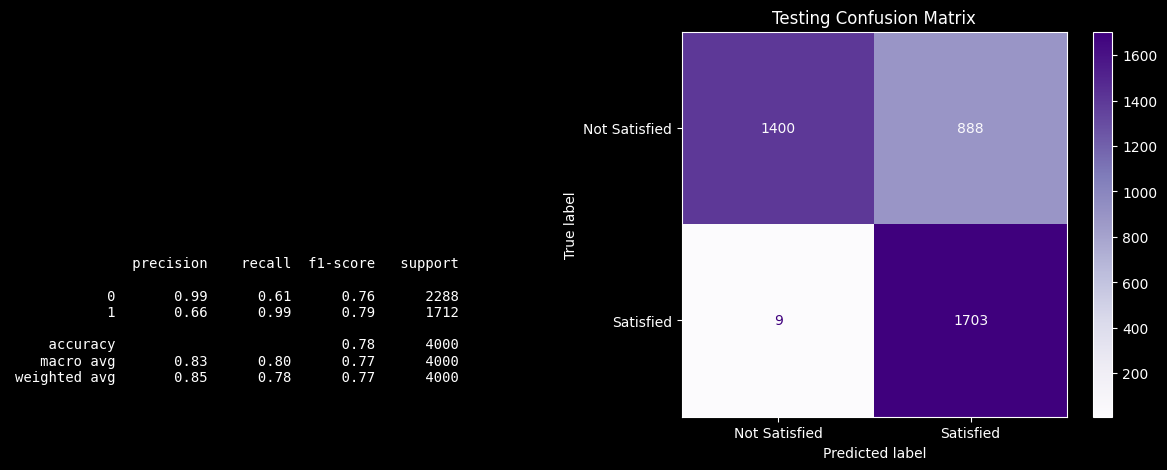

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate the model
dec_tree = DecisionTreeClassifier()

# Create and save predictions
train_preds, test_preds = train_and_predict(X_train_balanced_df, y_train_balanced, X_test_transformed_df, preprocessor, dec_tree)


### **Model Evaluation**

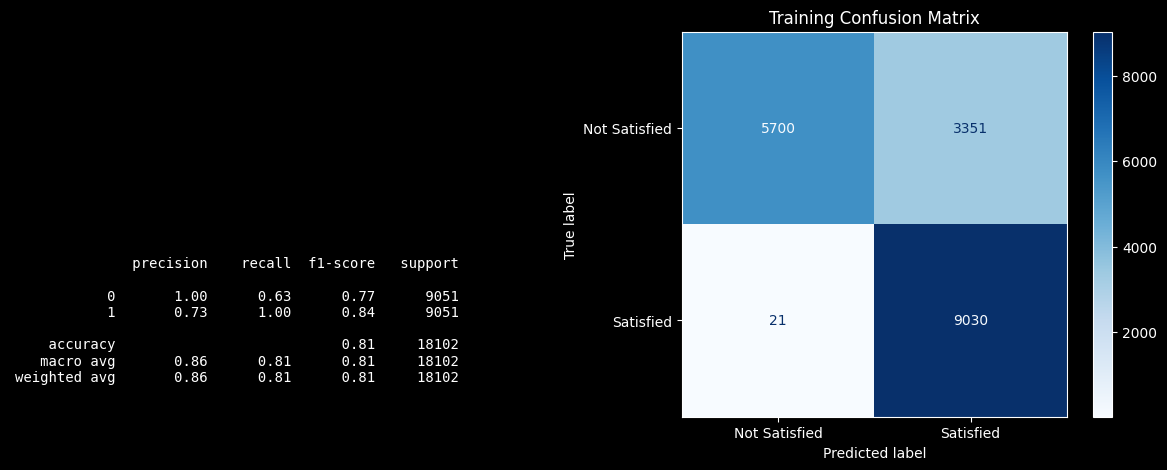

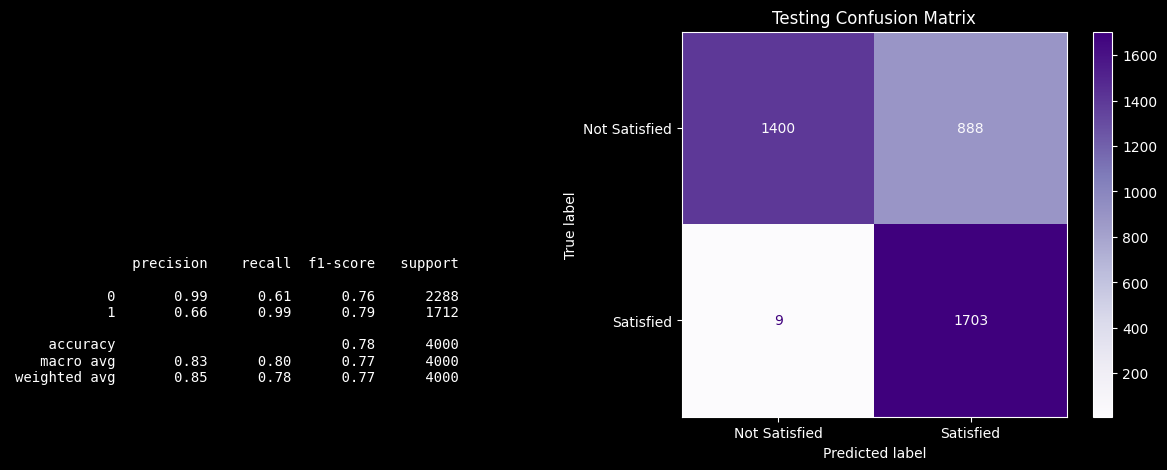

In [18]:
# Create reports for model evaluation

# Return train and test reports
train_report, test_report = evaluate_model(lgb_model, X_train_balanced_df, y_train_balanced, X_test_transformed_df, y_test)

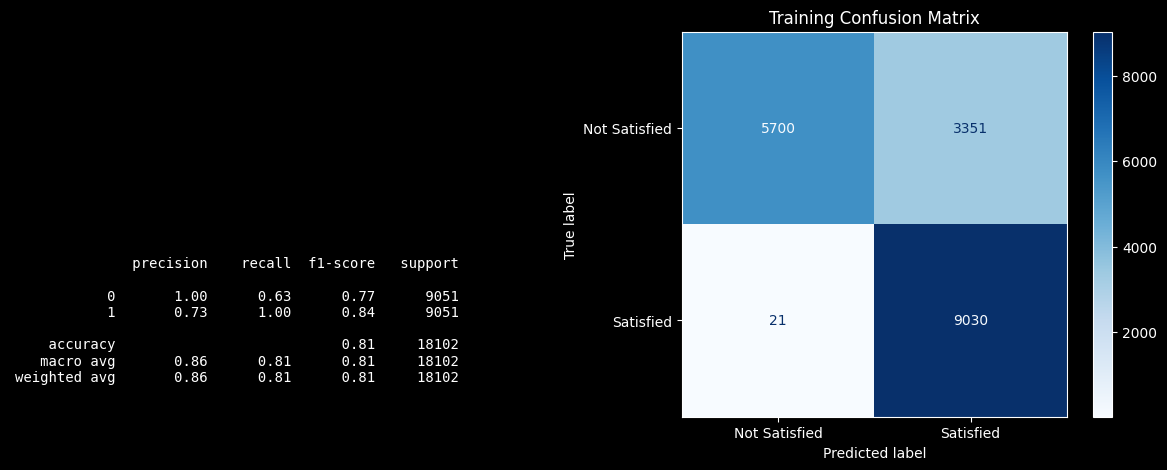

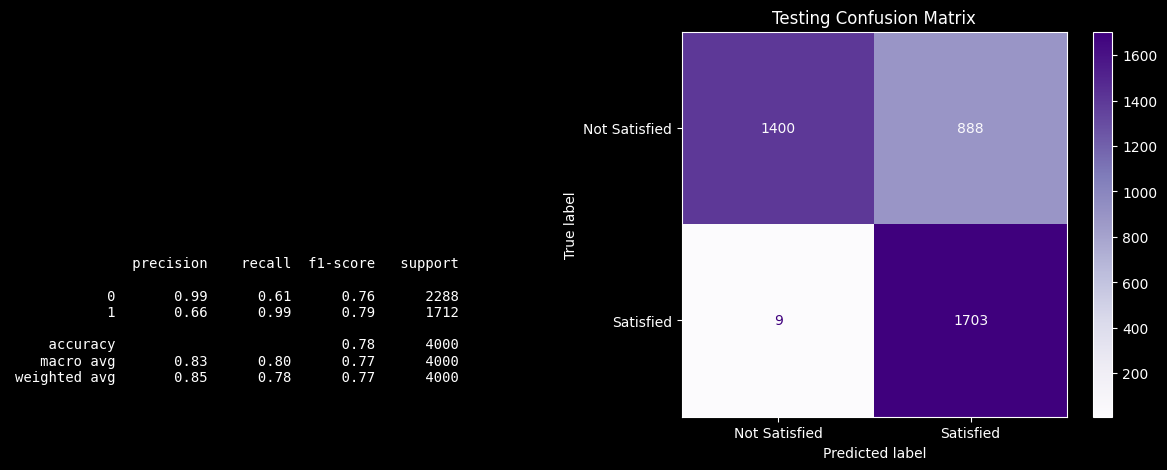

In [20]:
# Create report for decision trees

# Return train and test reports
train_report, test_report = evaluate_model(lgb_model, X_train_balanced_df, y_train_balanced, X_test_transformed_df, y_test)

### **Save Model**

In [22]:
import joblib

# Save the model
# def save_model(model, model_path):
#     try:
#         joblib.dump(model, model_path)
        
#         if os.path.exists(model_path):
#             print(f'Model saved successfully to {model_path}')
            
#         else:
#             print(f'Error saving model to {model_path}')
    
#     except Exception as error:
#         print(f'Error saving model to {model_path}: {error}')

import os
import joblib

# Save the model
def save_model(model, model_path):
    try:
        # Check if the directory exists, if not, create it
        directory = os.path.dirname(model_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        joblib.dump(model, model_path)
        
        if os.path.exists(model_path):
            print(f'Model saved successfully to {model_path}')
        else:
            print(f'Error saving model to {model_path}')
    
    except Exception as error:
        print(f'Error saving model to {model_path}: {error}')


In [23]:
# save the model

model_path='../models/lgb_model.joblib'
save_model(lgb_model, model_path)

Model saved successfully to ../models/lgb_model.joblib


In [24]:
# save the model

model_path='../models/dec_tree.joblib'
save_model(dec_tree, model_path)

Model saved successfully to ../models/dec_tree.joblib
